# Customer Segmentation & Recommendation System (Full Pipeline)



**Phases:**
1.  **Setup**: Mount Google Drive & Clone Repository.
2.  **Data Preparation**: Clean and Merge `profile`, `portfolio`, and `transcript` data.
3.  **Feature Engineering**: Create behavioral features (Offer completion rate, Channel usage).
4.  **Clustering (Unsupervised)**: Segment customers using K-Means.
5.  **Classification (Supervised)**: Train a Random Forest to predict segments for new users.
6.  **Recommendation**: Logic to map segments to the best offers.
7.  **Visualization**: Final report graphs.

## Phrase 1: setup google Colab

- Run the code below to mount google drive
- It will also pull the dataset from Github


In [1]:
import os
import sys

# 1. Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

# 2. Clone/Pull Repository
if IN_COLAB:
    # Define the path where you want the repo in your Drive
    # Change 'My Drive' to 'MyDrive' if needed, usually it's /content/drive/MyDrive
    repo_path = '/content/drive/MyDrive/Predict-customer-engagements'

    if not os.path.exists(repo_path):
        print(f"Cloning repository to {repo_path}...")
        !git clone https://github.com/wikiepeidia/Predict-customer-engagements.git "$repo_path"
    else:
        print(f"Repository already exists at {repo_path}. Pulling latest changes...")
        %cd "$repo_path"
        !git pull

    # Set working directory to the repo root
    %cd "$repo_path"
    print(f"Current working directory: {os.getcwd()}")
else:
    # If running locally, assume we are in the notebook folder, move up to root
    if os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')
    print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Cloning repository to /content/drive/MyDrive/Predict-customer-engagements...
Cloning into '/content/drive/MyDrive/Predict-customer-engagements'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 31 (delta 8), reused 26 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 10.09 MiB | 7.77 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/drive/MyDrive/Predict-customer-engagements
Current working directory: /content/drive/MyDrive/Predict-customer-engagements


# Package
- the code will execute required missing packages for Collab. If you see any package missing, please put in here and always run,

In [ ]:
!pip install

# Library import

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import ast

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load data

In [3]:
# Load Raw Data
try:
    portfolio = pd.read_csv('data/portfolio.csv')
    profile = pd.read_csv('data/profile.csv')
    transcript = pd.read_csv('data/transcript.csv')
    print("Datasets loaded successfully from data/ folder.")
except FileNotFoundError:
    print("Error: Data files not found. Ensure you are in the project root and data/ folder exists.")
    print("Files in current dir:", os.listdir('.'))

Datasets loaded successfully from data/ folder.


# Phrase 2: data preperation
- Data cleaning
- Customer360


In [4]:
# 1. Clean Profile
# Remove outliers (Age 118)
profile_clean = profile[profile['age'] != 118].copy()

# Convert dates and calculate membership days
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')
reference_date = profile_clean['became_member_on'].max()
profile_clean['membership_days'] = (reference_date - profile_clean['became_member_on']).dt.days
profile_clean.rename(columns={'id': 'customer_id'}, inplace=True)

# 2. Clean Portfolio
portfolio_clean = portfolio.copy()
portfolio_clean.rename(columns={'id': 'offer_id'}, inplace=True)

# One-hot encode channels
channels = ['web', 'email', 'mobile', 'social']
for channel in channels:
    portfolio_clean[channel] = portfolio_clean['channels'].apply(lambda x: 1 if channel in x else 0)
portfolio_clean.drop('channels', axis=1, inplace=True)

# 3. Clean Transcript
transcript_clean = transcript.copy()
transcript_clean.rename(columns={'person': 'customer_id'}, inplace=True)

# Extract 'value' column safely
def clean_value(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val

transcript_clean['value'] = transcript_clean['value'].apply(clean_value)

# Vectorized expansion of dictionary to columns
values_df = pd.DataFrame(transcript_clean['value'].tolist())
if 'offer id' in values_df.columns:
    values_df['offer_id'] = values_df['offer_id'].combine_first(values_df['offer id'])
    values_df.drop(columns=['offer id'], inplace=True)

transcript_clean = pd.concat([transcript_clean, values_df], axis=1)

print("Data cleaning complete.")

Data cleaning complete.


In [5]:
# Create Customer 360 View (Aggregating Transactions)
transactions = transcript_clean[transcript_clean['event'] == 'transaction']

# Basic Stats
transaction_agg = transactions.groupby('customer_id')['amount'].agg(['sum', 'count', 'mean']).rename(columns={
    'sum': 'total_amount',
    'count': 'transaction_count',
    'mean': 'average_transaction_value'
})

# Offer Interactions (Simple Counts)
offer_events = transcript_clean[transcript_clean['event'] != 'transaction']
offer_agg = pd.crosstab(offer_events['customer_id'], offer_events['event'])

# Merge to Profile
customer_360 = profile_clean.set_index('customer_id')
customer_360 = customer_360.join(transaction_agg, how='left')
customer_360 = customer_360.join(offer_agg, how='left')
customer_360.fillna(0, inplace=True)

print(f"Customer 360 View Shape: {customer_360.shape}")
customer_360.head(3)

Customer 360 View Shape: (14825, 12)


,Unnamed: 0,gender,age,became_member_on,income,membership_days,total_amount,transaction_count,average_transaction_value,offer completed,offer received,offer viewed
customer_id,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1,F,55,2017-07-15,112000.0,376,77.01,3.0,25.670000,1.0,2.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,3,F,75,2017-05-09,100000.0,443,159.27,7.0,22.752857,3.0,4.0,4.0
e2127556f4f64592b11af22de27a7932,5,M,68,2018-04-26,70000.0,91,57.73,3.0,19.243333,2.0,4.0,3.0


# Phrase 3: feature engineering

In [6]:
# 1. Offer Type Preferences (BOGO vs Discount)
merged_data = transcript_clean.merge(portfolio_clean, on='offer_id', how='left')
completed_offers = merged_data[merged_data['event'] == 'offer completed']

offer_type_counts = pd.crosstab(completed_offers['customer_id'], completed_offers['offer_type'])
offer_type_counts.columns = [f'{col}_completed' for col in offer_type_counts.columns]

# 2. Channel Usage (Viewed/Completed)
interaction_events = merged_data[merged_data['event'].isin(['offer viewed', 'offer completed'])]
channel_cols = ['web', 'email', 'mobile', 'social']
channel_usage = interaction_events.groupby('customer_id')[channel_cols].sum()
channel_usage.columns = [f'channel_{col}_count' for col in channel_usage.columns]

# 3. Completion Rate
if 'offer received' in customer_360.columns and 'offer completed' in customer_360.columns:
    customer_360['completion_rate'] = customer_360['offer completed'] / customer_360['offer received']
    customer_360['completion_rate'] = customer_360['completion_rate'].fillna(0.0).clip(upper=1.0)

# Merge everything
customer_features = customer_360.join(offer_type_counts, how='left')
customer_features = customer_features.join(channel_usage, how='left')
feature_fill_cols = list(offer_type_counts.columns) + list(channel_usage.columns)
customer_features[feature_fill_cols] = customer_features[feature_fill_cols].fillna(0)

# 4. Encode Gender
if 'gender' in customer_features.columns:
    customer_features = pd.get_dummies(customer_features, columns=['gender'], prefix='gender', drop_first=False)

# Drop non-numeric date column if exists
if 'became_member_on' in customer_features.columns:
    customer_features.drop(columns=['became_member_on'], inplace=True)

# 5. Scaling
scaler = StandardScaler()
features_to_scale = customer_features.columns
customer_features_scaled = pd.DataFrame(scaler.fit_transform(customer_features),
                                        columns=features_to_scale,
                                        index=customer_features.index)

print("Feature Engineering Complete.")
customer_features_scaled.head(3)

Feature Engineering Complete.


,Unnamed: 0,age,income,membership_days,total_amount,transaction_count,average_transaction_value,offer completed,offer received,offer viewed,completion_rate,bogo_completed,discount_completed,channel_web_count,channel_email_count,channel_mobile_count,channel_social_count,gender_F,gender_M,gender_O
customer_id,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,-1.735252,0.034889,2.157419,-0.349433,-0.307925,-1.034512,0.651691,-0.751176,-2.313047,-2.604592,0.038127,-0.027232,-1.050051,-1.463611,-1.889864,-1.807955,-1.858078,1.191146,-1.156702,-0.120448
78afa995795e4d85b5d9ceeca43f5fef,-1.734844,1.185430,1.601801,-0.189601,0.325036,-0.262682,0.475016,0.512935,-0.451989,0.493128,0.793253,1.837472,-1.050051,-0.212956,0.601332,0.790991,0.510126,1.191146,-1.156702,-0.120448
e2127556f4f64592b11af22de27a7932,-1.734435,0.782741,0.212756,-1.029314,-0.456278,-1.034512,0.262464,-0.119121,-0.451989,-0.281302,0.038127,-0.027232,-0.144255,0.203929,-0.229067,-0.075324,-0.910796,-0.839528,0.864527,-0.120448


# Phrase 4: clustering model

Running K-Means tests...


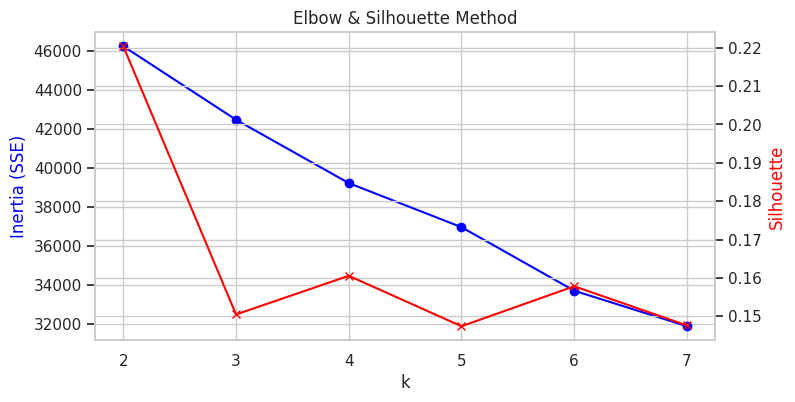

In [7]:
# 1. Determine Optimal K (Elbow & Silhouette)
sse = []
silhouette_scores = []
k_range = range(2, 8)  # Reduced range for speed in Colab demo
sample_data = customer_features_scaled.sample(n=3000, random_state=42) # Sample for speed

print("Running K-Means tests...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sample_data)
    sse.append(kmeans.inertia_)
    score = silhouette_score(sample_data, kmeans.predict(sample_data))
    silhouette_scores.append(score)

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia (SSE)', color='blue')
ax1.plot(k_range, sse, marker='o', color='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette', color='red')
ax2.plot(k_range, silhouette_scores, marker='x', color='red')
plt.title('Elbow & Silhouette Method')
plt.show()

In [8]:
# 2. Train Final Model (K=4 selected based on typical Starbucks Data performance)
k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(customer_features_scaled)

# Assign to DataFrames
customer_features['cluster'] = cluster_labels
customer_features_scaled['cluster'] = cluster_labels

print(f"Clusters assigned (K={k_final})")
print(customer_features['cluster'].value_counts())

Clusters assigned (K=4)
cluster
0    4307
2    3650
3    3544
1    3324
Name: count, dtype: int64


# Phrase 5: Clustering model

In [9]:
# 1. Prep Data
X = customer_features.drop('cluster', axis=1)
y = customer_features['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale (Fit on Train, Transform on Test)
rf_scaler = StandardScaler()
X_train_scaled = rf_scaler.fit_transform(X_train)
X_test_scaled = rf_scaler.transform(X_test)

# 2. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 3. Evaluate
y_pred = rf_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

Accuracy: 96.19%
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       861
           1       0.97      0.94      0.95       665
           2       0.96      0.97      0.96       730
           3       0.94      0.97      0.95       709

    accuracy                           0.96      2965
   macro avg       0.96      0.96      0.96      2965
weighted avg       0.96      0.96      0.96      2965



# Phrase 6 Recommendations

In [10]:
# 1. Define Strategy: Find Top Offer per Cluster
completed_offers_clean = transcript_clean[transcript_clean['event'] == 'offer completed']

# Merge to get cluster ID
merged_clusters = completed_offers_clean.merge(customer_features[['cluster']], left_on='customer_id', right_index=True)

# Find most frequent offer_id per cluster
popular_offers = merged_clusters.groupby(['cluster', 'offer_id']).size().reset_index(name='count')
popular_offers = popular_offers.sort_values(['cluster', 'count'], ascending=[True, False])
best_offers = popular_offers.groupby('cluster').head(1)

# Create Dictionary Map
cluster_rec_map = dict(zip(best_offers['cluster'], best_offers['offer_id']))

print("Recommendation Map (Cluster -> Offer):")
for c, oid in cluster_rec_map.items():
    otype = portfolio[portfolio['id'] == oid]['offer_type'].values[0]
    print(f"Cluster {c}: {oid} ({otype})")

Recommendation Map (Cluster -> Offer):
Cluster 0: 9b98b8c7a33c4b65b9aebfe6a799e6d9 (bogo)
Cluster 1: fafdcd668e3743c1bb461111dcafc2a4 (discount)
Cluster 2: fafdcd668e3743c1bb461111dcafc2a4 (discount)
Cluster 3: 9b98b8c7a33c4b65b9aebfe6a799e6d9 (bogo)


In [11]:
# 2. Inference Function
def recommend_for_new_user(user_dict):
    """Accepts raw user data dict -> Preprocesses -> Scales -> Predicts -> Recommends"""

    # Note: user_dict keys must match X_train columns exactly, or we need a proper mapping.
    # For this demo, we assume the input comes pre-formatted or we create a dummy DF.
    input_df = pd.DataFrame([user_dict])

    # Align columns (fill missing with 0)
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    input_df = input_df[X.columns] # Ensure order

    # Scale
    input_scaled = rf_scaler.transform(input_df)

    # Predict
    pred_cluster = rf_model.predict(input_scaled)[0]

    # Recommend
    rec_offer = cluster_rec_map.get(pred_cluster)
    return pred_cluster, rec_offer

# Test
dummy_user = {col: 0 for col in X.columns}
dummy_user['income'] = 80000
dummy_user['age'] = 30
dummy_user['transaction_count'] = 5

segment, offer = recommend_for_new_user(dummy_user)
print(f"\nTest User (Income 80k) assigned to Segment {segment}. Recommend Offer: {offer}")


Test User (Income 80k) assigned to Segment 0. Recommend Offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9


# Phrase 7: Visualation for Report

/tmp/ipython-input-401933554.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='cluster', data=customer_features, palette='viridis')


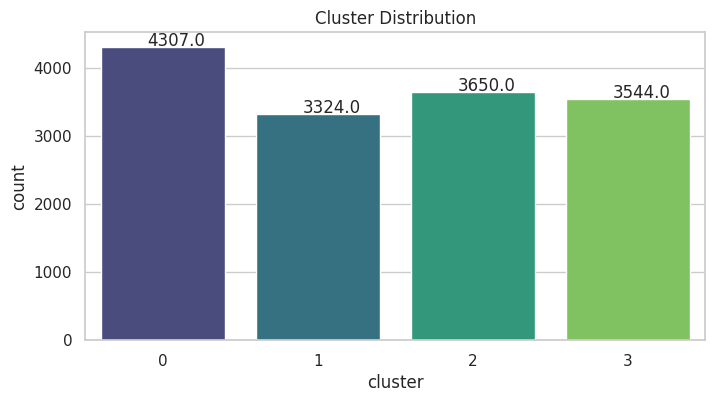

In [12]:
# Cluster Distribution
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='cluster', data=customer_features, palette='viridis')
plt.title('Cluster Distribution')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.3, p.get_height()+10))
plt.show()

/tmp/ipython-input-1022079940.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='age', data=customer_features, ax=axes[0], palette='viridis')
/tmp/ipython-input-1022079940.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='income', data=customer_features, ax=axes[1], palette='viridis')
/tmp/ipython-input-1022079940.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='total_amount', data=customer_features, ax=axes[2], palette='viridis')


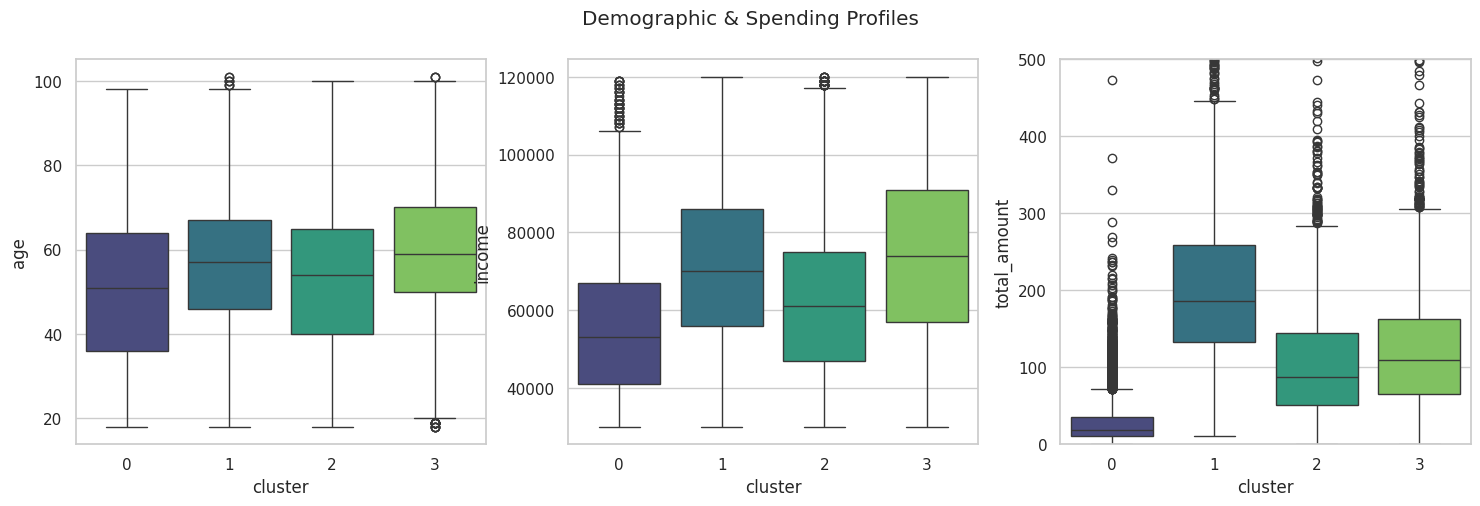

In [13]:
# Features Profiling
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='cluster', y='age', data=customer_features, ax=axes[0], palette='viridis')
sns.boxplot(x='cluster', y='income', data=customer_features, ax=axes[1], palette='viridis')
sns.boxplot(x='cluster', y='total_amount', data=customer_features, ax=axes[2], palette='viridis')
axes[2].set_ylim(0, 500) # Zoom in
plt.suptitle('Demographic & Spending Profiles')
plt.show()

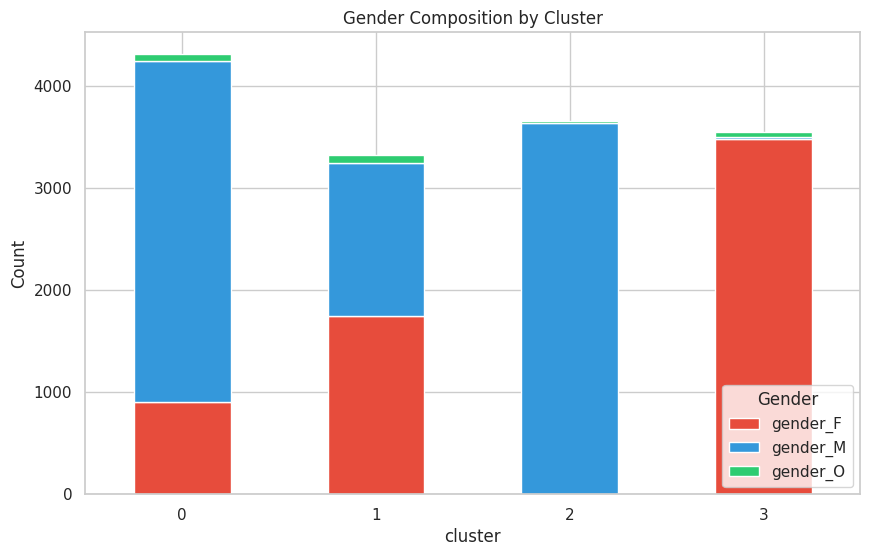

In [15]:
# Gender Breakdown
gender_cols = ['gender_F', 'gender_M', 'gender_O']
gender_data = customer_features.groupby('cluster')[gender_cols].sum()

gender_data.plot(kind='bar', stacked=True, color=['#e74c3c', '#3498db', '#2ecc71'], figsize=(10, 6))
plt.title('Gender Composition by Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.show()

/tmp/ipython-input-232510931.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='transaction_count', data=customer_features, ax=axes[0, 0], palette='viridis')
/tmp/ipython-input-232510931.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='average_transaction_value', data=customer_features, ax=axes[0, 1], palette='viridis')
/tmp/ipython-input-232510931.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='completion_rate', data=customer_features, ax=axes[1, 0], palette='viridis', ci=None)
/tmp/ipython-input-232510931.py:14: FutureWarning: 

Passing `palette` without assigning `hue` i

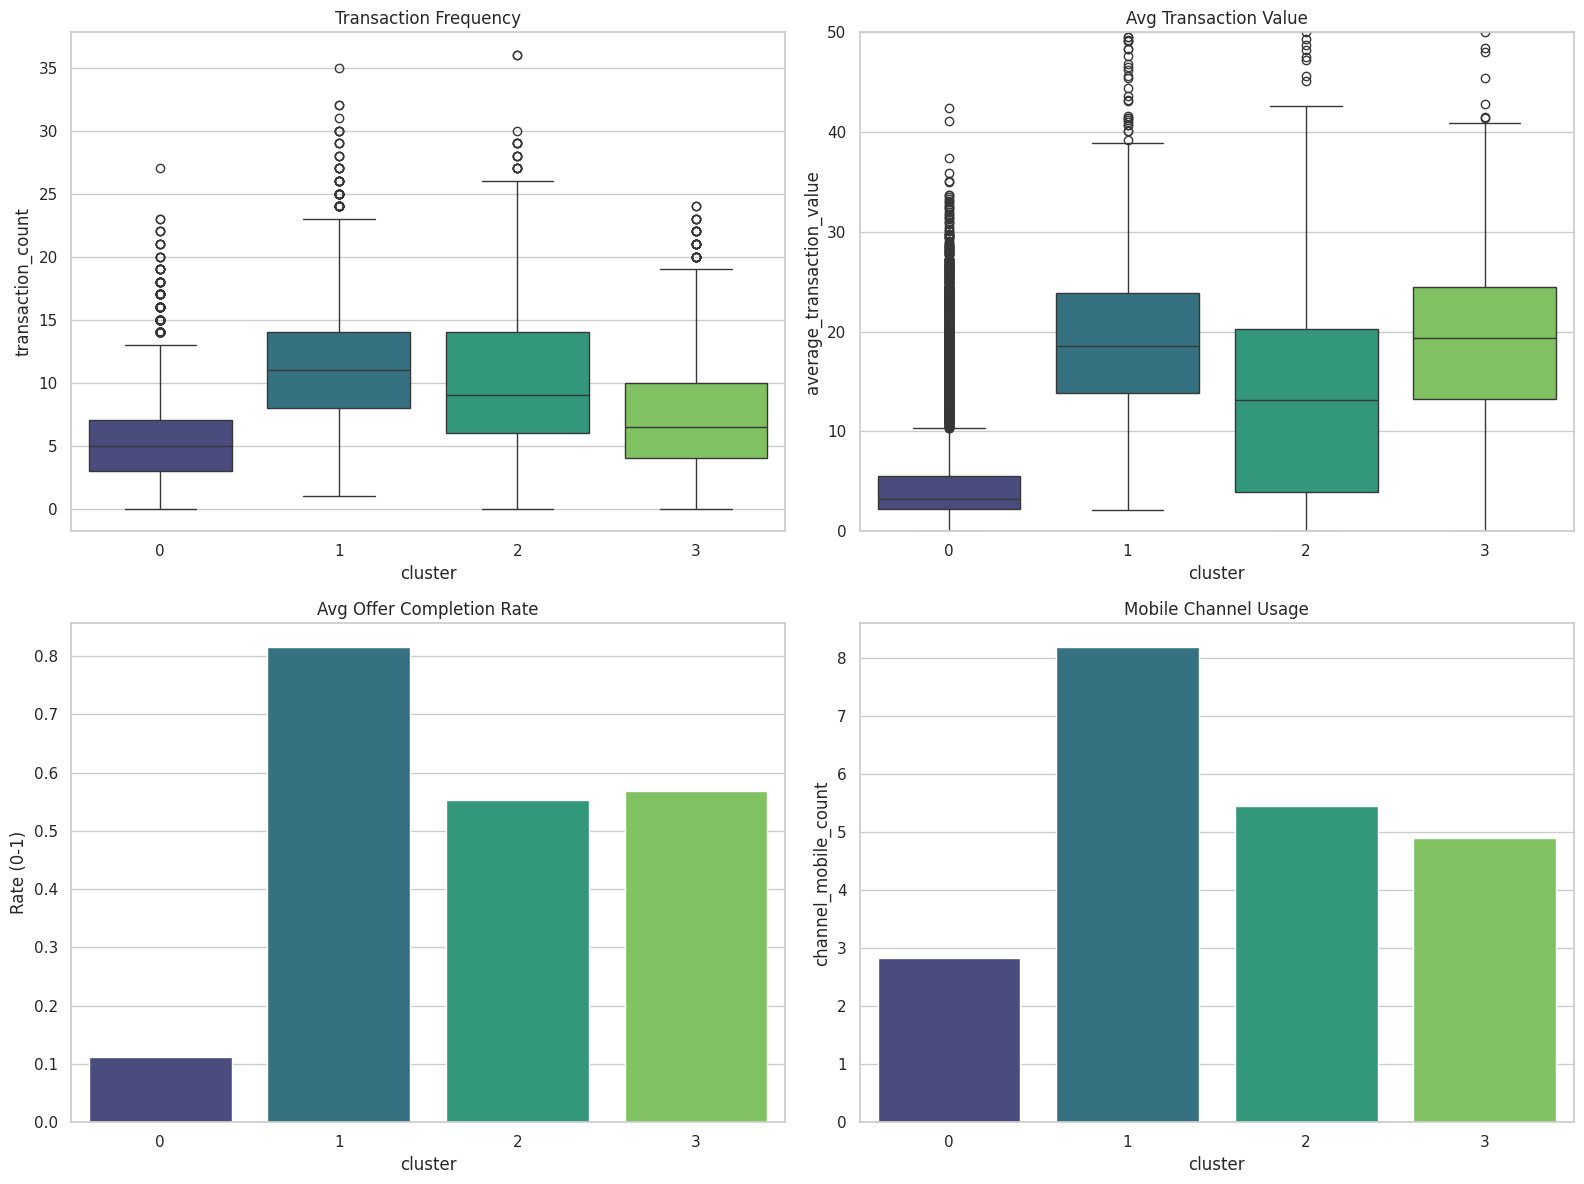

In [16]:
# Behavioral Profiling
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Transaction Count
sns.boxplot(x='cluster', y='transaction_count', data=customer_features, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Transaction Frequency')

# Average Transaction Value
sns.boxplot(x='cluster', y='average_transaction_value', data=customer_features, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Avg Transaction Value')
axes[0, 1].set_ylim(0, 50) # Zoom for clarity

# Offer Completion Rate
sns.barplot(x='cluster', y='completion_rate', data=customer_features, ax=axes[1, 0], palette='viridis', ci=None)
axes[1, 0].set_title('Avg Offer Completion Rate')
axes[1, 0].set_ylabel('Rate (0-1)')

# Mobile Channel Usage
sns.barplot(x='cluster', y='channel_mobile_count', data=customer_features, ax=axes[1, 1], palette='viridis', ci=None)
axes[1, 1].set_title('Mobile Channel Usage')

plt.tight_layout()
plt.show()

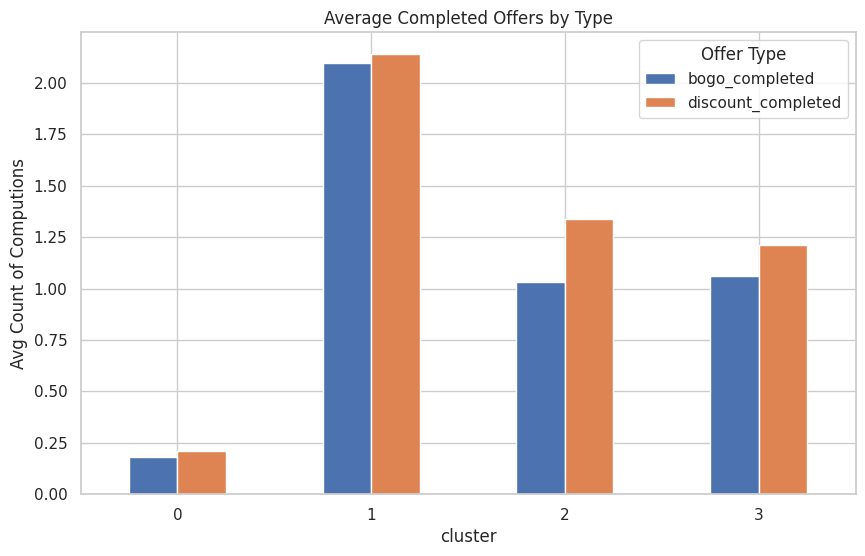

In [17]:
# Offer Type Preferences
offer_types = customer_features.groupby('cluster')[['bogo_completed', 'discount_completed']].mean()

offer_types.plot(kind='bar', figsize=(10, 6))
plt.title('Average Completed Offers by Type')
plt.ylabel('Avg Count of Computions')
plt.xticks(rotation=0)
plt.legend(title='Offer Type')
plt.show()